In [113]:
# importing packages
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# PRE PROCESSING FROM CLEANSED DATA FILE

In [114]:
# import cleansed data
file_path = Path("Data/churn_data.csv")

In [115]:
# Create a DataFrame
churn_data_df = pd.read_csv(file_path)
churn_data_df.head(5)

,city,zip,lat,long,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,CLTV
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,3239
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,2701
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,5372
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,5003
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,5340


In [116]:
# View of data set
churn_data_df.describe()

,zip,lat,long,tenure,monthly_charges,total_charges,churn,CLTV
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,93523.032565,36.283307,-119.799215,32.421786,64.798208,2283.300441,0.265785,4401.445108
std,1865.515958,2.456118,2.157588,24.545260,30.085974,2266.771362,0.441782,1182.414266
min,90001.000000,32.555828,-124.301372,1.000000,18.250000,18.800000,0.000000,2003.000000
25%,92102.000000,34.030915,-121.815412,9.000000,35.587500,401.450000,0.000000,3469.750000
50%,93552.500000,36.391777,-119.735410,29.000000,70.350000,1397.475000,0.000000,4527.500000
75%,95354.000000,38.227285,-118.043237,55.000000,89.862500,3794.737500,1.000000,5381.000000
max,96161.000000,41.962127,-114.192901,72.000000,118.750000,8684.800000,1.000000,6500.000000


In [117]:
# Encode all the categorical data
categorical_cols = ['city', 'gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service',
                   'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
                    'contract', 'paperless_billing', 'payment_method']
encoders = {}

for i in categorical_cols:
    encoders[i] = LabelEncoder()
    churn_data_df[i] = encoders[i].fit_transform(churn_data_df[i])

churn_data_df.head()

,city,zip,lat,long,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,CLTV
0,562,90003,33.964131,-118.272783,1,0,0,0,2,1,...,0,0,0,0,1,3,53.85,108.15,1,3239
1,562,90005,34.059281,-118.307420,0,0,0,1,2,1,...,0,0,0,0,1,2,70.70,151.65,1,2701
2,562,90006,34.048013,-118.293953,0,0,0,1,8,1,...,0,2,2,0,1,2,99.65,820.50,1,5372
3,562,90010,34.062125,-118.315709,0,0,1,1,28,1,...,2,2,2,0,1,2,104.80,3046.05,1,5003
4,562,90015,34.039224,-118.266293,1,0,0,1,49,1,...,0,2,2,0,1,0,103.70,5036.30,1,5340


In [118]:
# Split the data into X and y features
#X = churn_data_df.iloc[:, :-1]
#y = churn_data_df.iloc[:, -1]

X = churn_data_df.drop(columns= 'churn')
y = churn_data_df['churn']

In [119]:
# Summary stats of data set
X.describe()

,city,zip,lat,long,gender,senior_citizen,partner,dependents,tenure,phone_service,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,CLTV
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,593.711889,93523.032565,36.283307,-119.799215,0.504693,0.162400,0.482509,0.230375,32.421786,0.903299,...,0.903868,0.796359,0.984926,0.992890,0.688567,0.592719,1.573237,64.798208,2283.300441,4401.445108
std,314.937096,1865.515958,2.456118,2.157588,0.500014,0.368844,0.499729,0.421103,24.545260,0.295571,...,0.880178,0.861674,0.885285,0.885385,0.832934,0.491363,1.067504,30.085974,2266.771362,1182.414266
min,0.000000,90001.000000,32.555828,-124.301372,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,2003.000000
25%,337.000000,92102.000000,34.030915,-121.815412,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.587500,401.450000,3469.750000
50%,601.000000,93552.500000,36.391777,-119.735410,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,1397.475000,4527.500000
75%,869.000000,95354.000000,38.227285,-118.043237,1.000000,0.000000,1.000000,0.000000,55.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.862500,3794.737500,5381.000000
max,1128.000000,96161.000000,41.962127,-114.192901,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,6500.000000


In [120]:
# Checking the balance of the Target values- Data is imbalanced.
y.value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [156]:
# Creating Train and Test split for X and y- 80 to 20 split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=1)

In [157]:
# Data count for train and test
c= pd.DataFrame(y_train)
k = pd.DataFrame(y_test)
print(c['churn'].value_counts())
print(k['churn'].value_counts())

0    3590
1    1332
Name: churn, dtype: int64
0    1573
1     537
Name: churn, dtype: int64


In [123]:
# Creating standard scaler instance and fit the training data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [124]:
# Scaling Train and Test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# SIMPLE LOGISTIC REGRESSION CLASSIFIER

In [125]:
lr_clf = LogisticRegression(solver='lbfgs', random_state=1)
lr_clf.fit(X_train_scaled, y_train) 

LogisticRegression(random_state=1)

In [126]:
# Calculate the balanced accuracy score i.e. make predictions/calculate accuracy. Looks good in this instance.
y_pred = lr_clf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7302436009901728

In [127]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[1401,  172],
       [ 231,  306]], dtype=int64)

<AxesSubplot:>

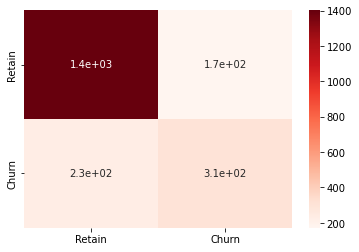

In [128]:
# Display Confusion Matrix heatmap
lr_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(lr_clf_cm, annot=True, cmap='Reds')

In [129]:
# Print the imbalanced classification report- based on below results model is performing well.
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.89      0.57      0.87      0.71      0.52      1573
          1       0.64      0.57      0.89      0.60      0.71      0.49       537

avg / total       0.80      0.81      0.65      0.81      0.71      0.52      2110



In [130]:
# ROC-AUC score
roc_auc_score(y_test, y_pred)

0.7302436009901728

# Review results

Since the precision for predicting churn rate and recall is low, there is potentrial to improve this model.

# Over Sampling- does not help- makes precision worse!

In this section, will use oversampling alogrithm to balance the data set.

In [131]:
# Resample the training data with the RandomOversampler- note scaled data is resampled.
# implement random oversampling- all libraries loaded at the start
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

# View the count of target classes with Counter
Counter(y_resampled)

Counter({1: 3590, 0: 3590})

In [132]:
# Train the Logistic Regression model using the resampled data
lr_cf_model = LogisticRegression(solver='lbfgs', random_state=1)
lr_cf_model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [133]:
# Calculate the balanced accuracy score
y_pred = lr_cf_model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7623715373842341

In [134]:
y_test.describe()

count    2110.000000
mean        0.254502
std         0.435684
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64

In [135]:
# Display the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[1174,  399],
       [ 119,  418]], dtype=int64)

<AxesSubplot:>

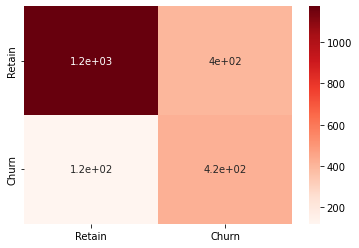

In [136]:
# Display Confusion Matrix heatmap
lr_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(lr_clf_cm, annot=True, cmap='Reds')

In [137]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.75      0.78      0.82      0.76      0.58      1573
          1       0.51      0.78      0.75      0.62      0.76      0.58       537

avg / total       0.81      0.75      0.77      0.77      0.76      0.58      2110



In [138]:
# ROC-AUC score
roc_auc_score(y_test, y_pred)

0.7623715373842341

# Balanced Random Forest Classifier

In [139]:
# Resample the training data with the BalancedRandomForestClassifier
brf_clf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf_clf = brf_clf.fit(X_train_scaled, y_train)

In [140]:
# Calculated the balanced accuracy score
y_pred = brf_clf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.76087219027798

In [141]:
# Display the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[1181,  392],
       [ 123,  414]], dtype=int64)

<AxesSubplot:>

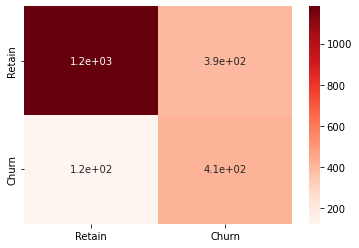

In [142]:
# Display the Confusion Matrix heatmap
brf_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(brf_clf_cm, annot=True, cmap='Reds')

In [143]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.75      0.77      0.82      0.76      0.58      1573
          1       0.51      0.77      0.75      0.62      0.76      0.58       537

avg / total       0.81      0.76      0.77      0.77      0.76      0.58      2110



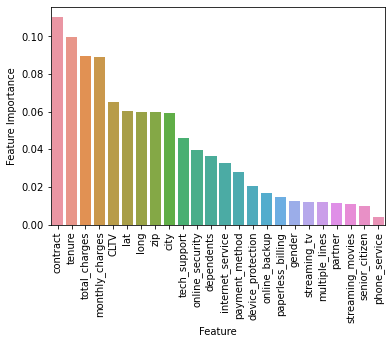

In [144]:
# List the features sorted in descending order by feature importance
feature_list = {i:j for i, j in zip(brf_clf.feature_importances_, X.columns)}
fi = pd.DataFrame(sorted(feature_list.items(), reverse=True), columns=['Feature Importance', 'Feature'])
plot = sns.barplot(x='Feature', y='Feature Importance', data=fi)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90);

# Easy Ensemble Classifier

In [145]:
# Train the Classifier
eec_clf = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec_clf.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [146]:
# Calculated the balanced accuracy score
y_pred = eec_clf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7512912853187104

In [147]:
# Display the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[1145,  428],
       [ 121,  416]], dtype=int64)

<AxesSubplot:>

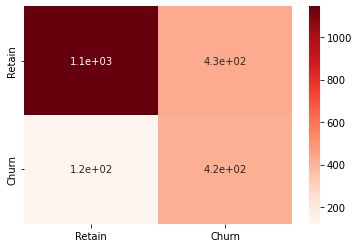

In [148]:
# Display the Confusion Matrix heatmap
eec_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(eec_clf_cm, annot=True, cmap='Reds')

In [149]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.73      0.77      0.81      0.75      0.56      1573
          1       0.49      0.77      0.73      0.60      0.75      0.57       537

avg / total       0.80      0.74      0.76      0.75      0.75      0.56      2110



# XGBOOST CLASSIFIER

In [150]:
# Train the XGBoost classifier
xgb_clf = XGBClassifier(random_state=1, 
                        learning_rate=0.35, 
                        eval_metric='mlogloss')

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.35, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [151]:
# Predict and Evaluate the results
y_pred = xgb_clf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7108059538227136

In [152]:
# Display the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[1375,  198],
       [ 243,  294]], dtype=int64)

<AxesSubplot:>

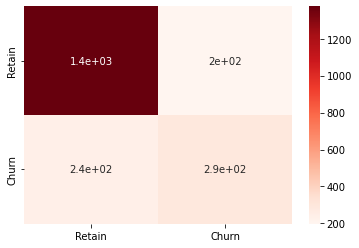

In [153]:
# Display the Confusion Matrix heatmap
xgb_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(xgb_clf_cm, annot=True, cmap='Reds')

In [154]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.87      0.55      0.86      0.69      0.49      1573
          1       0.60      0.55      0.87      0.57      0.69      0.46       537

avg / total       0.79      0.79      0.63      0.79      0.69      0.49      2110



<AxesSubplot:title={'center':'Feature Importance (XGBoost)'}, xlabel='F score', ylabel='Features'>

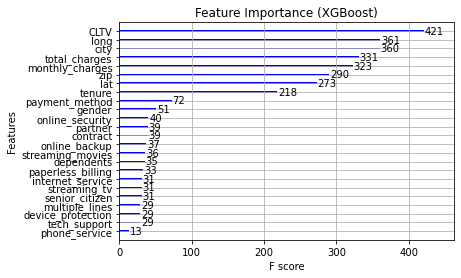

In [155]:
xgboost.plot_importance(xgb_clf, title="Feature Importance (XGBoost)", color='Blue')